WIP solution guide for w1d4 by Chris MacLeod

Notes:
- Logit 50 is alligator? Is this list right? https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [3]:
import einops
import matplotlib.pyplot as plt
import torch
from torchvision import models

# CM: The channels are in RGB order? How to find this out if you don't know?
model = models.resnet34(pretrained=True)
_ = model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)


def imshow(img, figsize=(6, 6), fig=None):
    if fig is None:
        fig = plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)
    # CM: are these labeled wrong? I thought height comes before width?
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    # CM: why do we need detach here?
    shown = plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])
    return shown


cpu


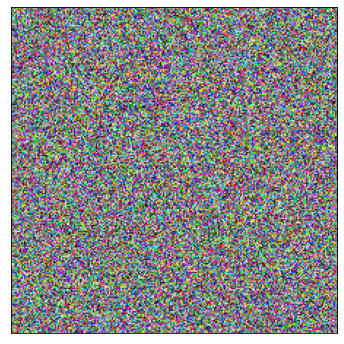

In [26]:
torch.manual_seed(0)
imshow(torch.rand((1, 3, 224, 224)))

In [81]:
# CM TODO: this is not explained well at all in the instructions
# Should it really make it red?
import numpy as np

# w1d4.py did this but I don't know why
class LinearDecorrelateColor(torch.nn.Module):
    def __init__(self):
        color_correlation_svd_sqrt = np.asarray(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]])
        max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))
        self.mat = torch.tensor(color_correlation_svd_sqrt / max_norm_svd_sqrt, dtype=torch.float32)

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)

# This seems to follow the instructions    
class LinearDecorrelateColor2(torch.nn.Module):
    def __init__(self):
        self.mat = torch.tensor(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]], dtype=torch.float32)

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)

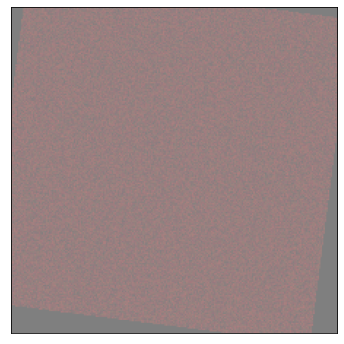

In [82]:
from torchvision.transforms import ColorJitter, RandomAffine, Compose
# Tip: these expect CHW or BCHW format, which we are already using.
# Tip: if you get an error about im_size or expecting Image but got Tensor, this may indicate an old version of torchvision.
# I tested this on torchvision 0.10.1.
transform = Compose([
    ColorJitter(),
    RandomAffine(degrees=10, translate=(0.05, 0.05)),
    LinearDecorrelateColor2(),
    torch.nn.Sigmoid(),
])
img = torch.rand((1, 3, 224, 224))
imshow(transform(img))

In [83]:
scale = torch.load('result.pt')
scale.shape

torch.Size([3, 224, 113])

In [88]:
# CM: how many iterations is best to see something? 20? Or stop when we're not changing by much?
import tqdm

def random_image():
    return torch.rand((1, 3, 224, 224)).requires_grad_(True)

# CM: do we just mess around with init_sd or is there a way to pick it?
def freq_image(init_sd=0.1):
    spectra = torch.view_as_complex(init_sd * torch.randn((1, 3, 224, 113, 2)))
    # Tip: Specifying s also determines the dimensions to FFT over.
    # So irfft2 and irfftn are the same here
    # CM: does the normalization mode really matter here?
    img2 = torch.fft.irfft2(scale * spectra, s=(224, 224)).float()
    print(img2.abs().mean(), img2.max(), img2.std())
    return img2.requires_grad_(True)

#img = random_image()
img = freq_image()


model.requires_grad_(False)

optim = torch.optim.Adam([img], lr=0.05)
n_iterations = 40
imgs = [img.detach()]
for i in tqdm.notebook.trange(n_iterations):
    # Different random transforms each time
    optim.zero_grad()
    transformed = transform(img)    
    logits = model(transformed) # (batch, output_classes)
    loss = -logits[0, 50]
    loss.backward()
    optim.step()
    imgs.append(transformed.detach())

tensor(0.0888) tensor(0.4418) tensor(0.1088)


  0%|          | 0/40 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1127) tensor(0.5127) tensor(0.1426)


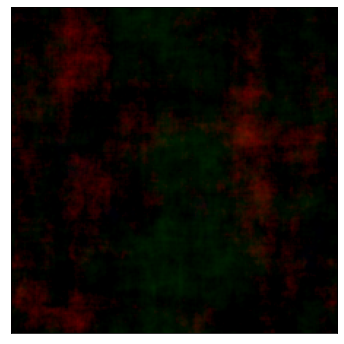

In [89]:
imshow(LinearDecorrelateColor()(freq_image()))

In [90]:
# CM: should we be trying to get these into some certain range
# so the softmax doesn't squish them too bad?
img.min(), img.max()

(tensor(-1.7398, grad_fn=<MinBackward1>),
 tensor(1.7917, grad_fn=<MaxBackward1>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


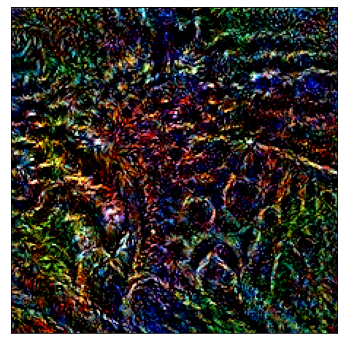

In [91]:
imshow(img)